## Makemore MLP

In [1]:
import torch

In [2]:
import torch.nn.functional as F

In [3]:
from matplotlib import pyplot as plt

### Build vocabulary

In [4]:
words = open('names.txt','r').read().splitlines()

In [5]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


### Build dataset

In [6]:
block_size = 3
X, Y = [], []
for w in words[:5]:
    print(w)
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        print(''.join(itos[i] for i in context), '--->', itos[ix])
        context = context[1:] + [ix]

X = torch.tensor(X)
Y = torch.tensor(Y)
        

emma
... ---> e
..e ---> m
.em ---> m
emm ---> a
mma ---> .
olivia
... ---> o
..o ---> l
.ol ---> i
oli ---> v
liv ---> i
ivi ---> a
via ---> .
ava
... ---> a
..a ---> v
.av ---> a
ava ---> .
isabella
... ---> i
..i ---> s
.is ---> a
isa ---> b
sab ---> e
abe ---> l
bel ---> l
ell ---> a
lla ---> .
sophia
... ---> s
..s ---> o
.so ---> p
sop ---> h
oph ---> i
phi ---> a
hia ---> .


In [7]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([32, 3]), torch.int64, torch.Size([32]), torch.int64)

In [8]:
C = torch.randn([27,2])
C[3]

tensor([0.5505, 0.7114])

In [9]:
F.one_hot(torch.tensor(3), num_classes=27).float() @ C

tensor([0.5505, 0.7114])

In [10]:
# 31th example 3rd character is an "a" = tensor(1)
X[31][2]

tensor(1)

In [11]:
emb = C[X]
# shape is [32,3,2] 32 training examples, of 3 (block size), 2 dimensions (embedding dimesion)
emb.shape

torch.Size([32, 3, 2])

In [12]:
emb[:,0,:].shape

torch.Size([32, 2])

### Weights and biases
We need to flatten one dimension to perform the multiplication. The input layer receives a vector of 3 by 2 (block size and embedding size) 

In [13]:
torch.cat(torch.unbind(emb,1),1).shape
# concatenation is ineffiecient and creates all kinds of memory

torch.Size([32, 6])

In [14]:
emb.view(32,6)

tensor([[ 1.0735, -1.5263,  1.0735, -1.5263,  1.0735, -1.5263],
        [ 1.0735, -1.5263,  1.0735, -1.5263, -1.7757, -0.4388],
        [ 1.0735, -1.5263, -1.7757, -0.4388,  0.6716,  1.6750],
        [-1.7757, -0.4388,  0.6716,  1.6750,  0.6716,  1.6750],
        [ 0.6716,  1.6750,  0.6716,  1.6750, -0.9014,  0.3808],
        [ 1.0735, -1.5263,  1.0735, -1.5263,  1.0735, -1.5263],
        [ 1.0735, -1.5263,  1.0735, -1.5263, -1.3452, -1.6329],
        [ 1.0735, -1.5263, -1.3452, -1.6329, -0.2315,  1.2540],
        [-1.3452, -1.6329, -0.2315,  1.2540,  0.3876, -1.2364],
        [-0.2315,  1.2540,  0.3876, -1.2364,  0.5246, -0.2191],
        [ 0.3876, -1.2364,  0.5246, -0.2191,  0.3876, -1.2364],
        [ 0.5246, -0.2191,  0.3876, -1.2364, -0.9014,  0.3808],
        [ 1.0735, -1.5263,  1.0735, -1.5263,  1.0735, -1.5263],
        [ 1.0735, -1.5263,  1.0735, -1.5263, -0.9014,  0.3808],
        [ 1.0735, -1.5263, -0.9014,  0.3808,  0.5246, -0.2191],
        [-0.9014,  0.3808,  0.5246, -0.2

In [15]:
# input size and neurons

W1 = torch.randn((6,100))
b1 = torch.randn(100)

In [16]:
h = emb.view(emb.shape[0], 6) @ W1 + b1
# or emb.view(-1, 6) with "-1" pytorch will infer what the other dimension should be to sum up to the correct one

In [17]:
# two broadcastable shapes:
(emb.view(emb.shape[0], 6) @ W1).shape, b1.shape

(torch.Size([32, 100]), torch.Size([100]))

In [18]:
h = torch.tanh(emb.view(-1,6) @ W1 + b1)

In [19]:
h.shape

torch.Size([32, 100])

In [20]:
# 27 characters are output
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

In [21]:
logits = h @ W2 + b2

In [22]:
logits.shape

torch.Size([32, 27])

In [23]:
logits.shape

torch.Size([32, 27])

In [24]:
counts = logits.exp()

In [25]:
counts.max()

tensor(9.4884e+15)

In [26]:
# counts are normalized so they sum to 1
prob = counts / counts.sum(1, keepdims = True)

In [27]:
prob[0].sum()

tensor(1.0000)

In [28]:
# actual probabilities for the correct output character (for now without training)
# torch.arange(32), Y this means "example i, character Y (the correct character)"
prob[torch.arange(32), Y]

tensor([5.0785e-01, 6.6423e-13, 4.1730e-16, 4.5848e-11, 8.6571e-08, 1.1483e-10,
        8.0714e-10, 5.6594e-18, 1.6788e-11, 9.9371e-01, 1.6359e-13, 4.1197e-16,
        1.0153e-14, 5.5143e-17, 1.4599e-11, 2.6594e-12, 2.6499e-05, 4.9500e-13,
        1.4864e-23, 7.8471e-18, 3.3116e-01, 1.0642e-12, 8.7261e-01, 1.1315e-07,
        1.0320e-05, 1.5032e-11, 2.0714e-17, 1.9036e-10, 3.1265e-14, 4.9128e-19,
        1.5601e-05, 1.2884e-14])

In [29]:
prob.shape

torch.Size([32, 27])

In [30]:
torch.arange(32), Y

(tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
         18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]),
 tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0,  9, 19,
          1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9,  1,  0]))

In [31]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,2), generator = g)
W1 = torch.randn((6,100), generator = g)
b1 = torch.randn(100, generator = g)
W2 = torch.randn((100,27), generator = g)
b2 = torch.randn(27, generator = g)

In [32]:
parameters = [C, W1, b1, W2, b2]

In [33]:
num_params = sum(p.nelement() for p in parameters)
num_params

3481

In [34]:
emb = C[X]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
counts = logits.exp()
prob = counts / counts.sum(1, keepdims=True)
loss = -prob[torch.arange(32), Y].log().mean()
loss

tensor(17.7697)

In [35]:
# the previous cell is the same as cross_entropy
F.cross_entropy(logits, Y)

tensor(17.7697)

**cross entropy** measures the difference between two probability distributions. is used in classification problems. If $P$ is our target distribution (in this case $Y$) and $Q$ is an approximation of $Q$ (in this case $logits$), the **cross entropy** is computed as follows:
$$H(P,Q) = - \sum_{x \in X} P(x) \cdot \log{Q(x)}$$

In [36]:
for p in parameters:
    p.requires_grad = True

## Training Loop
#### Overfitting one batch of 32 examples

In [37]:
for _ in range(1000):
    # forward pass
    emb = C[X]
    h = torch.tanh(emb.view(-1,6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y)

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    for p in parameters:
        p.data += -0.1 * p.grad

print(loss.item())

0.2561309337615967


#### Training on the full data set
Random selected minibatches are used to train the model. For each mini batch a gradient is computed and an optimization of the parameters is performed.

In [38]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,2), generator = g)
W1 = torch.randn((6,100), generator = g)
b1 = torch.randn(100, generator = g)
W2 = torch.randn((100,27), generator = g)
b2 = torch.randn(27, generator = g)

In [39]:
parameters = [C, W1, b1, W2, b2]

In [40]:
for p in parameters:
    p.requires_grad = True

In [41]:
iterations = 1000

In [76]:
loss_track = []
lr_track = []
for i in range(100):
    # getting random mini batches
    # 32 indices are randomly generated
    ix = torch.randint(0, X.shape[0], (32,))

    # forward pass
    emb = C[X[ix]]
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y[ix])

    # track
    loss_track.append(loss.item())
    lr_track.append(lre[i])
    # backward pass
    for p in parameters:
        p.grad = None

    # when .backward() is kicked off, the autograd function executes backprop differentiating the computational graph from p.
    loss.backward()
    
    # update
    for p in parameters:
        p.data += -lrs[i]*p.grad

#### Finding a good learning rate 
The idea is iterating into an exponential increasing list of learning rates and find which ones make the loss more stable

In [77]:
lre = torch.linspace(-3, 0, iterations)
lrs = 10**lre

In [78]:
loss_track

[7.310534477233887,
 6.790839672088623,
 7.690193176269531,
 5.775766372680664,
 8.135406494140625,
 5.311097621917725,
 8.806873321533203,
 7.434634685516357,
 6.212513446807861,
 6.521396160125732,
 7.628840446472168,
 6.003509044647217,
 5.680726051330566,
 5.34309196472168,
 6.8733649253845215,
 6.420897006988525,
 6.944580078125,
 8.397017478942871,
 7.240819931030273,
 6.080768585205078,
 5.77609920501709,
 7.346543788909912,
 7.945135593414307,
 8.458189010620117,
 7.063790321350098,
 7.349616527557373,
 7.3743367195129395,
 10.315694808959961,
 6.0294599533081055,
 6.3698015213012695,
 7.942902088165283,
 7.458354473114014,
 6.7075653076171875,
 6.995547294616699,
 6.499564170837402,
 7.016817092895508,
 7.493383884429932,
 7.209637641906738,
 5.121764183044434,
 7.586089134216309,
 5.877751350402832,
 6.840388774871826,
 5.516308784484863,
 7.630855560302734,
 6.522823333740234,
 8.662284851074219,
 6.38564395904541,
 7.475413799285889,
 7.826220989227295,
 6.9571943283081055,

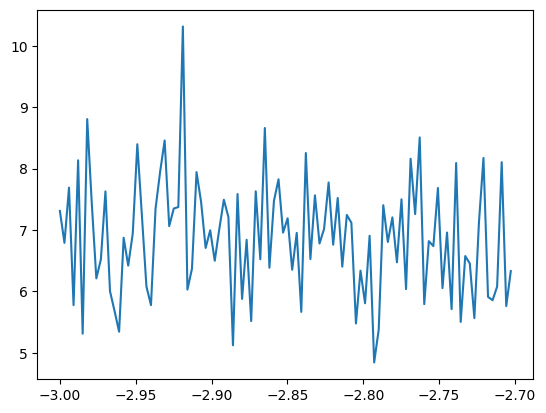

In [79]:
plt.plot(lr_track, loss_track)

In [45]:
# splits, large hidden layer, large embedding, visualizing embeddings

## Data set splits
Usually a dataset is split into 3 parts: training, validation and test split.
- Training: for optimizing parameters
- Validation: for optimizing hyperparameters
- Test: To evaluate performance

### Build data set + Splits

In [190]:
def build_dataset(words):
    block_size = 5
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)

    return X,Y


In [191]:
import random

random.seed(42)
random.shuffle(words)

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

In [194]:
X.shape

torch.Size([228146, 3])

### Training on `Xtr`

In [122]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,2), generator = g)
W1 = torch.randn((6,300), generator = g)
b1 = torch.randn(300, generator = g)
W2 = torch.randn((300,27), generator = g)
b2 = torch.randn(27, generator = g)

In [123]:
parameters = [C, W1, b1, W2, b2]

In [124]:
for p in parameters:
    p.requires_grad = True

In [125]:
iterations = 30000

In [126]:
loss_track = []
lr_track = []
for i in range(10000):
    # getting random mini batches
    # 32 indices are randomly generated
    ix = torch.randint(0, Xtr.shape[0], (32,))

    # forward pass
    emb = C[Xtr[ix]]
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])

    # backward pass
    for p in parameters:
        p.grad = None

    # when .backward() is kicked off, the autograd function executes backprop differentiating the computational graph from p.
    loss.backward()
    
    # update
    lr = 0.01
    for p in parameters:
        p.data += -lr*p.grad

In [127]:
print(loss.item())

2.460955858230591


### Evaluating on dev
When training and dev loss are similar it means we are not memorizing and not over fitting

In [128]:
emb = C[Xdev]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)

In [129]:
print(loss.item())

2.565492630004883


## Experiment: larger layer


In [130]:
lossi = []
stepi = []

for i in range(40000):
    ix = torch.randint(0, Xtr.shape[0], (32,))

    # forward pass
    emb = C[Xtr[ix]]
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])

    # backward pass
    for p in parameters:
        p.grad = None
        
    # -- backprop
    loss.backward()
    
    # update
    lr = 0.01
    for p in parameters:
        p.data += -lr*p.grad

    # track
    lossi.append(loss.item())
    stepi.append(i)

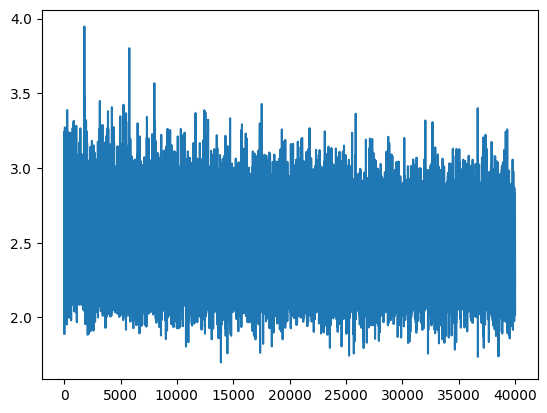

In [131]:
plt.plot(stepi, lossi)

In [120]:
emb = C[Xdev]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.3234, grad_fn=<NllLossBackward0>)

## Visualizing embeddings

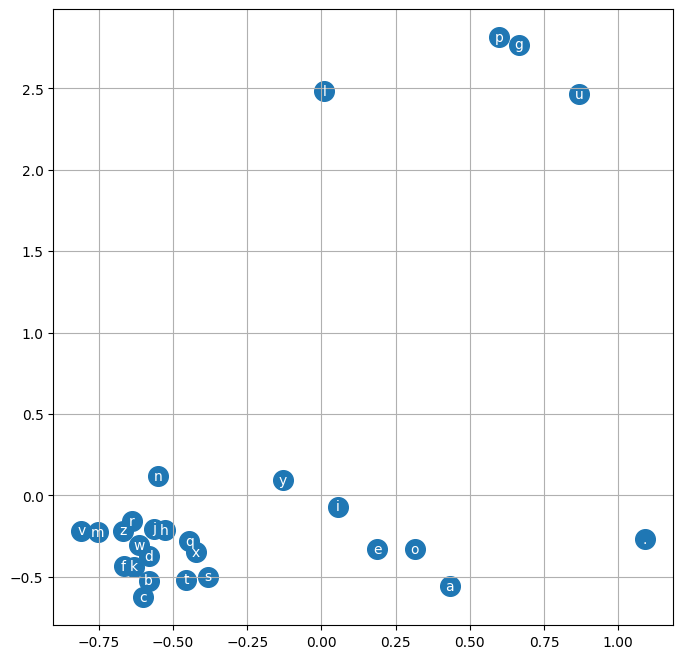

In [121]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s = 200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha = "center", va="center", color = "white")
plt.grid('minor')

## Larger embedding size
A larger layer did not lead to better results so let's try to increase the embedding size from 2 to 10

In [195]:
g = torch.Generator().manual_seed(2147483647)
# embeddings
C = torch.randn((27,10), generator = g)
W1 = torch.randn((50,250), generator = g)
b1 = torch.randn(250, generator = g)
W2 = torch.randn((250,27), generator = g)
b2 = torch.randn(27, generator = g)
parameters = [C, W1, b1, W2, b2]

In [196]:
sum(p.nelement() for p in parameters)

19797

In [197]:
for p in parameters:
    p.requires_grad = True

In [207]:
lri = []
lossi = []
stepi = []
for i in range(200000):
    ix = torch.randint(0, Xtr.shape[0], (50,))

    # forward pass
    emb = C[Xtr[ix]]
    h = torch.tanh(emb.view(-1, 50) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])

    for p in parameters:
        p.grad = None
        
    loss.backward()

    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    stepi.append(i)
    lossi.append(loss.log10().item())

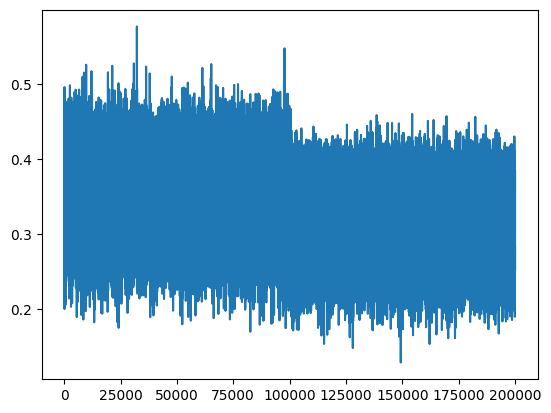

In [208]:
plt.plot(stepi, lossi)

In [209]:
emb = C[Xdev]
h = torch.tanh(emb.view(-1, 50) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1494, grad_fn=<NllLossBackward0>)

In [210]:
emb = C[Xte]
h = torch.tanh(emb.view(-1, 50) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Yte)
loss

tensor(2.1630, grad_fn=<NllLossBackward0>)

## Sampling from the model

In [220]:
g = torch.Generator().manual_seed(2147483647 + 10)

num_names = 30

block_size = 5

for _ in range(num_names):
    out = list()
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(-1, 50) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim = 1)
        ix = torch.multinomial(probs, num_samples = 1, generator = g).item()
        context = context[1:] + [ix]
        out.append(ix)
        # 0 is dot, name is finished
        if ix == 0:
            break
    print(''.join(itos[i] for i in out))

carmah.
amille.
khisma.
xilet.
khalana.
ejrahnen.
dellyn.
jarquis.
ramari.
chaiia.
kaleigh.
hamriow.
dessan.
sulin.
alivabiu.
jaelon.
jaryxi.
jaceelinsa.
med.
ediia.
gianley.
frana.
aseon.
jersyn.
naqqocore.
jooje.
calaira.
nekpela.
luuo.
zoessa.
